# Импортируем все нужные библиотеки

In [ ]:
import sys
import itertools
import nltk
import numpy as np
import pandas as pd
import re
import string
from multiprocessing import Pool
from nltk.corpus import stopwords
from pymystem3 import Mystem
import pickle
import operator 
from nltk.stem import SnowballStemmer
import pymorphy2
import time
from math import log
import scipy.sparse as sp
import lightgbm as lgb
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
import matplotlib.pyplot as plt
russian_stop = set(stopwords.words('russian'))

NUM_CPUs = 24

import os
os.environ['OMP_NUM_THREADS'] = '24'

# Загружаем данные

In [2]:
df = pd.read_csv('../avito_test/train.csv')
test = pd.read_csv('../avito_test/test.csv')



# Обрабатываем текстовые данные. Лемматизируем и в заголовке к словам ставим часть речи.

In [3]:
lemmer = Mystem()

def preproc1(text):
    text = re.sub(u"[^a-zа-я0-9]", " ", text.lower())
    text = re.sub(u"\s+", " ", text)
    tokens = lemmer.lemmatize(text)
    if len(tokens) == 0:
        print('None')
        return 'none'
    return " ".join([i.strip() for i in tokens if i.strip()])

def preproc2(text):
    text = re.sub(u"[^a-zа-я0-9]", " ", text.lower())
    text = re.sub(u"\s+", " ", text)
    tokens = lemmer.lemmatize(text)
    tmp = []
    for lem, res in zip(tokens, lemmer.analyze(text)):
        lem = lem.strip()
        if lem:
            if "analysis" in res:
                try:
                    res = res["analysis"][0]["gr"].split(",")[0].split("=")[0]
                except:
                    res = "UNKN"
            else:
                res = "UNKN"
            lem = "{}_{}".format(lem, res)
            tmp.append(lem)
    return " ".join(tmp)

In [ ]:
df['preproc1_des'] = [preproc1(el) for el in df['description']]
df['preproc2_tit'] = [preproc2(el) for el in df['title']]

In [4]:
test['preproc1_des'] = [preproc1(el) for el in test['description']]
test['preproc2_tit'] = [preproc2(el) for el in test['title']]

# Нормализуем цену

In [ ]:
for min_prc, max_prc in zip([0, 1, 10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90, 99], [1, 10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90, 99, 100]):
    line_min = np.percentile(df['price'], min_prc)
    line_max = np.percentile(df['price'], max_prc)
    df['price_' + str(max_prc) + '_log_nrm'] = [log(el,  line_max) if line_min < el <= line_max else 0 for el in df['price']]


In [5]:
for min_prc, max_prc in zip([0, 1, 10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90, 99], [1, 10, 20, 30, 40, 45, 50, 55, 60, 70, 80, 90, 99, 100]):
    line_min = np.percentile(test['price'], min_prc)
    line_max = np.percentile(test['price'], max_prc)
    test['price_' + str(max_prc) + '_log_nrm'] = [log(el,  line_max) if line_min < el <= line_max else 0 for el in test['price']]


In [6]:
df.to_csv('prep_dataset.csv', encoding='utf-8')
df.to_csv('prep_test_dataset.csv', encoding='utf-8')

In [9]:
df = pd.read_csv('prep_dataset.csv', encoding='utf-8')
test = pd.read_csv('prep_test_dataset.csv', encoding='utf-8')
df.dropna(inplace = True)

# Текстовые статистики используются при обучении градиентного бустинга

In [10]:
textfeats = ["description","title"]
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words


# Векторизация текста выделением tf-idf статистик

In [11]:
start_preproc = time.time()
tfidf_params = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    "min_df":3,
    "max_df":.9,
    "smooth_idf":True
}

def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('preproc1_des',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=50000,
            **tfidf_params,
            preprocessor=get_col('preproc1_des'))),
        
        ('preproc2_tit',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_params,
            preprocessor=get_col('preproc2_tit')))
    ])

print("Starting vectorization..")

vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()


price_f = ['price_1_log_nrm', 'price_10_log_nrm', 'price_20_log_nrm', 'price_30_log_nrm', 'price_40_log_nrm', 'price_45_log_nrm', 'price_50_log_nrm', 'price_55_log_nrm', 'price_60_log_nrm', 'price_70_log_nrm', 'price_80_log_nrm', 'price_90_log_nrm', 'price_99_log_nrm', 'price_100_log_nrm']
x_prc = sp.csr_matrix(df[price_f])
x_tf = sp.hstack([ready_df, x_prc], format='csr')
vocab = tfvocab + price_f

print("Feature Names Length: ",len(vocab))
print(f"Preprocessing Runtime: {(time.time() - start_preproc)/60 : 0.2f} Minutes")

Starting vectorization..
Feature Names Length:  156348
Preprocessing Runtime:  2.50 Minutes


#  То же самое делаем с отложенной выборкой

In [17]:
ready_df_test = vectorizer.transform(test.to_dict('records'))
tfvocab_test = vectorizer.get_feature_names()


price_f = ['price_1_log_nrm', 'price_10_log_nrm', 'price_20_log_nrm', 'price_30_log_nrm', 'price_40_log_nrm', 'price_45_log_nrm', 'price_50_log_nrm', 'price_55_log_nrm', 'price_60_log_nrm', 'price_70_log_nrm', 'price_80_log_nrm', 'price_90_log_nrm', 'price_99_log_nrm', 'price_100_log_nrm']
x_prc_test = sp.csr_matrix(test[price_f])
x_tf_test = sp.hstack([ready_df_test, x_prc_test], format='csr')
vocab_test = tfvocab_test + price_f


# Деление выборки на две части: для обучения и для валидации

In [13]:
y = df['category_id'].as_matrix()
X_train, X_valid, y_train, y_valid = train_test_split(x_tf, y,
                                                  random_state=42,
                                                  test_size=0.2,
                                                  shuffle=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


#  Обучаем логистическую регрессию. Модель простая довольно, но ее получилось быстро улучшить до хорошего результата. 

In [14]:
print("Starting training..")

start_train=time.time()

log_regr = LogisticRegression(C = 3.0, multi_class='ovr', solver='lbfgs', n_jobs=NUM_CPUs) 
log_regr.fit(X_train, y_train)
print(f"Training Runtime: {(time.time() - start_train)/60. : 0.2f} Minutes")

print("Starting evaluation..")
y_pred_train = log_regr.predict(X_train)
y_pred_valid = log_regr.predict(X_valid)


train_accuracy = accuracy_score(y_train, y_pred_train)
valid_accuracy = accuracy_score(y_valid, y_pred_valid)

print(f"Training accuracy: {train_accuracy:0.4f}, validation accuracy: {valid_accuracy:0.4f}")

Starting training..
Training Runtime:  1.33 Minutes
Starting evaluation..
Training accuracy: 0.9551, validation accuracy: 0.8925


# Предсказание категории объявления для тестовой выборки

In [23]:
prediction_test = log_regr.predict(x_tf_test)
answer = pd.DataFrame()
answer['item_id'] = test['item_id']
answer['category_id'] = prediction_test.tolist()
answer.to_csv('test_answer.csv', index=False, encoding='utf-8')

In [15]:
with open('log_regr_model.pickle', 'wb') as pickle_file:
    pickle.dump(log_regr, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    

# Добавляем к tf-idf признакам, ценовым признакам еще и текстовые статистики

In [193]:
features_stat = ['description_num_chars', 'description_num_words', 'description_num_unique_words', 'description_words_vs_unique', 'title_num_chars', 'title_num_words', 'title_num_unique_words', 'title_words_vs_unique']
features_stat_csr = sp.csr_matrix(df[features_stat])
x = sp.hstack([ready_df, x_prc, features_stat_csr], format='csr')
vocab = tfvocab + price_f + features_stat
print("Feature Names Length: ",len(vocab))


156356
Feature Names Length:  156356


In [194]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y,
                                                  random_state=42,
                                                  test_size=0.2,
                                                  shuffle=True)

#   Обучаем градиентный бустинг. В итоге он выдал результат хуже логистической регрессии, но можно еще было найти способы увеличить accuracy  подбором параметров, так как бустинг сильно переобучился

In [207]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'num_class': 54,
    'metric': 'multi_error',
    'max_depth': 9,
    'num_leaves': 30,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 1,
    'num_threads': 24, 
    
}  

In [208]:
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=vocab)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=vocab)

modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=100
)
print(f'Training Runtime {(time.time()-modelstart)/60} minutes')


[1]	train's multi_error: 0.355755	valid's multi_error: 0.358786
Training until validation scores don't improve for 100 rounds.
[2]	train's multi_error: 0.263791	valid's multi_error: 0.267127
[3]	train's multi_error: 0.235596	valid's multi_error: 0.238651
[4]	train's multi_error: 0.221048	valid's multi_error: 0.224035
[5]	train's multi_error: 0.211678	valid's multi_error: 0.215197
[6]	train's multi_error: 0.206351	valid's multi_error: 0.210114
[7]	train's multi_error: 0.202031	valid's multi_error: 0.206131
[8]	train's multi_error: 0.198159	valid's multi_error: 0.2025
[9]	train's multi_error: 0.195041	valid's multi_error: 0.199741
[10]	train's multi_error: 0.191647	valid's multi_error: 0.196369
[11]	train's multi_error: 0.190153	valid's multi_error: 0.195145
[12]	train's multi_error: 0.187884	valid's multi_error: 0.192884
[13]	train's multi_error: 0.186517	valid's multi_error: 0.192355
[14]	train's multi_error: 0.185832	valid's multi_error: 0.191712
[15]	train's multi_error: 0.184818	val

[127]	train's multi_error: 0.1482	valid's multi_error: 0.164948
[128]	train's multi_error: 0.147995	valid's multi_error: 0.164948
[129]	train's multi_error: 0.147715	valid's multi_error: 0.164876
[130]	train's multi_error: 0.147557	valid's multi_error: 0.164772
[131]	train's multi_error: 0.147339	valid's multi_error: 0.164554
[132]	train's multi_error: 0.147176	valid's multi_error: 0.164533
[133]	train's multi_error: 0.146968	valid's multi_error: 0.16445
[134]	train's multi_error: 0.146745	valid's multi_error: 0.164149
[135]	train's multi_error: 0.146499	valid's multi_error: 0.163973
[136]	train's multi_error: 0.146312	valid's multi_error: 0.163724
[137]	train's multi_error: 0.14611	valid's multi_error: 0.163589
[138]	train's multi_error: 0.14584	valid's multi_error: 0.163517
[139]	train's multi_error: 0.14569	valid's multi_error: 0.16333
[140]	train's multi_error: 0.145508	valid's multi_error: 0.163278
[141]	train's multi_error: 0.145322	valid's multi_error: 0.16305
[142]	train's mult

[252]	train's multi_error: 0.12591	valid's multi_error: 0.151556
[253]	train's multi_error: 0.125737	valid's multi_error: 0.15139
[254]	train's multi_error: 0.12556	valid's multi_error: 0.151286
[255]	train's multi_error: 0.125423	valid's multi_error: 0.151183
[256]	train's multi_error: 0.125319	valid's multi_error: 0.151048
[257]	train's multi_error: 0.125156	valid's multi_error: 0.150892
[258]	train's multi_error: 0.125031	valid's multi_error: 0.150757
[259]	train's multi_error: 0.124912	valid's multi_error: 0.150695
[260]	train's multi_error: 0.124767	valid's multi_error: 0.150726
[261]	train's multi_error: 0.124595	valid's multi_error: 0.150612
[262]	train's multi_error: 0.124474	valid's multi_error: 0.150602
[263]	train's multi_error: 0.124346	valid's multi_error: 0.150602
[264]	train's multi_error: 0.124193	valid's multi_error: 0.150477
[265]	train's multi_error: 0.124046	valid's multi_error: 0.150456
[266]	train's multi_error: 0.123919	valid's multi_error: 0.15028
[267]	train's 

[377]	train's multi_error: 0.11014	valid's multi_error: 0.142936
[378]	train's multi_error: 0.110049	valid's multi_error: 0.142853
[379]	train's multi_error: 0.10993	valid's multi_error: 0.142822
[380]	train's multi_error: 0.109805	valid's multi_error: 0.142749
[381]	train's multi_error: 0.109681	valid's multi_error: 0.142749
[382]	train's multi_error: 0.109593	valid's multi_error: 0.142728
[383]	train's multi_error: 0.109468	valid's multi_error: 0.142604
[384]	train's multi_error: 0.109318	valid's multi_error: 0.142583
[385]	train's multi_error: 0.109258	valid's multi_error: 0.142448
[386]	train's multi_error: 0.109149	valid's multi_error: 0.142386
[387]	train's multi_error: 0.109074	valid's multi_error: 0.142334
[388]	train's multi_error: 0.108942	valid's multi_error: 0.142344
[389]	train's multi_error: 0.10889	valid's multi_error: 0.142272
[390]	train's multi_error: 0.108755	valid's multi_error: 0.14221
[391]	train's multi_error: 0.108698	valid's multi_error: 0.142261
[392]	train's 

[502]	train's multi_error: 0.099235	valid's multi_error: 0.137853
[503]	train's multi_error: 0.0991753	valid's multi_error: 0.137853
[504]	train's multi_error: 0.0990949	valid's multi_error: 0.137811
[505]	train's multi_error: 0.0989912	valid's multi_error: 0.13779
[506]	train's multi_error: 0.0989056	valid's multi_error: 0.137687
[507]	train's multi_error: 0.0988304	valid's multi_error: 0.137656
[508]	train's multi_error: 0.098737	valid's multi_error: 0.137614
[509]	train's multi_error: 0.0986748	valid's multi_error: 0.137552
[510]	train's multi_error: 0.0985918	valid's multi_error: 0.137479
[511]	train's multi_error: 0.098527	valid's multi_error: 0.13751
[512]	train's multi_error: 0.098457	valid's multi_error: 0.137438
[513]	train's multi_error: 0.0983428	valid's multi_error: 0.137407
[514]	train's multi_error: 0.0982469	valid's multi_error: 0.137407
[515]	train's multi_error: 0.0981587	valid's multi_error: 0.137355
[516]	train's multi_error: 0.0980705	valid's multi_error: 0.137365
[

[625]	train's multi_error: 0.0908688	valid's multi_error: 0.134409
[626]	train's multi_error: 0.0908402	valid's multi_error: 0.134357
[627]	train's multi_error: 0.090778	valid's multi_error: 0.134295
[628]	train's multi_error: 0.0907106	valid's multi_error: 0.134284
[629]	train's multi_error: 0.090638	valid's multi_error: 0.134232
[630]	train's multi_error: 0.0905809	valid's multi_error: 0.134201
[631]	train's multi_error: 0.0905083	valid's multi_error: 0.134191
[632]	train's multi_error: 0.0904098	valid's multi_error: 0.13416
[633]	train's multi_error: 0.0903786	valid's multi_error: 0.134108
[634]	train's multi_error: 0.0903138	valid's multi_error: 0.134118
[635]	train's multi_error: 0.0902541	valid's multi_error: 0.134108
[636]	train's multi_error: 0.0902152	valid's multi_error: 0.134108
[637]	train's multi_error: 0.0901556	valid's multi_error: 0.134056
[638]	train's multi_error: 0.0900934	valid's multi_error: 0.134077
[639]	train's multi_error: 0.0900026	valid's multi_error: 0.13416

[748]	train's multi_error: 0.0844009	valid's multi_error: 0.132054
[749]	train's multi_error: 0.0843543	valid's multi_error: 0.132054
[750]	train's multi_error: 0.0842894	valid's multi_error: 0.132095
[751]	train's multi_error: 0.0842583	valid's multi_error: 0.132054
[752]	train's multi_error: 0.0842272	valid's multi_error: 0.132075
[753]	train's multi_error: 0.0841753	valid's multi_error: 0.132085
[754]	train's multi_error: 0.0841131	valid's multi_error: 0.132085
[755]	train's multi_error: 0.0840742	valid's multi_error: 0.132044
[756]	train's multi_error: 0.0840327	valid's multi_error: 0.131992
[757]	train's multi_error: 0.0839886	valid's multi_error: 0.13195
[758]	train's multi_error: 0.0839627	valid's multi_error: 0.131867
[759]	train's multi_error: 0.0839134	valid's multi_error: 0.131826
[760]	train's multi_error: 0.0838797	valid's multi_error: 0.131763
[761]	train's multi_error: 0.0838511	valid's multi_error: 0.131722
[762]	train's multi_error: 0.0837915	valid's multi_error: 0.131

[871]	train's multi_error: 0.0789419	valid's multi_error: 0.130176
[872]	train's multi_error: 0.0788797	valid's multi_error: 0.130166
[873]	train's multi_error: 0.0788511	valid's multi_error: 0.130187
[874]	train's multi_error: 0.0788019	valid's multi_error: 0.130166
[875]	train's multi_error: 0.0787474	valid's multi_error: 0.130145
[876]	train's multi_error: 0.0787422	valid's multi_error: 0.130114
[877]	train's multi_error: 0.0786981	valid's multi_error: 0.130166
[878]	train's multi_error: 0.0786566	valid's multi_error: 0.130166
[879]	train's multi_error: 0.0786255	valid's multi_error: 0.130135
[880]	train's multi_error: 0.0785737	valid's multi_error: 0.130145
[881]	train's multi_error: 0.078514	valid's multi_error: 0.130124
[882]	train's multi_error: 0.0784725	valid's multi_error: 0.130083
[883]	train's multi_error: 0.0784492	valid's multi_error: 0.130041
[884]	train's multi_error: 0.0783999	valid's multi_error: 0.130031
[885]	train's multi_error: 0.0783766	valid's multi_error: 0.130

[994]	train's multi_error: 0.0742531	valid's multi_error: 0.128662
[995]	train's multi_error: 0.0742272	valid's multi_error: 0.1286
[996]	train's multi_error: 0.0741961	valid's multi_error: 0.128568
[997]	train's multi_error: 0.0741546	valid's multi_error: 0.128548
[998]	train's multi_error: 0.0741209	valid's multi_error: 0.128579
[999]	train's multi_error: 0.074082	valid's multi_error: 0.12862
[1000]	train's multi_error: 0.0740327	valid's multi_error: 0.12862
[1001]	train's multi_error: 0.0740223	valid's multi_error: 0.1286
[1002]	train's multi_error: 0.0740041	valid's multi_error: 0.1286
[1003]	train's multi_error: 0.0739808	valid's multi_error: 0.128568
[1004]	train's multi_error: 0.0739419	valid's multi_error: 0.12861
[1005]	train's multi_error: 0.0739004	valid's multi_error: 0.128589
[1006]	train's multi_error: 0.0738563	valid's multi_error: 0.128568
[1007]	train's multi_error: 0.0738122	valid's multi_error: 0.128537
[1008]	train's multi_error: 0.0737837	valid's multi_error: 0.128

[1116]	train's multi_error: 0.070306	valid's multi_error: 0.127407
[1117]	train's multi_error: 0.0702567	valid's multi_error: 0.127427
[1118]	train's multi_error: 0.0702127	valid's multi_error: 0.127386
[1119]	train's multi_error: 0.0701841	valid's multi_error: 0.127355
[1120]	train's multi_error: 0.070153	valid's multi_error: 0.127324
[1121]	train's multi_error: 0.0701037	valid's multi_error: 0.127344
[1122]	train's multi_error: 0.0700648	valid's multi_error: 0.127334
[1123]	train's multi_error: 0.0700571	valid's multi_error: 0.127334
[1124]	train's multi_error: 0.0700207	valid's multi_error: 0.127272
[1125]	train's multi_error: 0.0699818	valid's multi_error: 0.127241
[1126]	train's multi_error: 0.0699352	valid's multi_error: 0.127241
[1127]	train's multi_error: 0.0699196	valid's multi_error: 0.127261
[1128]	train's multi_error: 0.0698755	valid's multi_error: 0.127261
[1129]	train's multi_error: 0.069834	valid's multi_error: 0.127261
[1130]	train's multi_error: 0.0698055	valid's multi

[1237]	train's multi_error: 0.0667842	valid's multi_error: 0.126504
[1238]	train's multi_error: 0.0667557	valid's multi_error: 0.126494
[1239]	train's multi_error: 0.0667298	valid's multi_error: 0.126483
[1240]	train's multi_error: 0.066709	valid's multi_error: 0.126463
[1241]	train's multi_error: 0.0667012	valid's multi_error: 0.126494
[1242]	train's multi_error: 0.0666572	valid's multi_error: 0.126494
[1243]	train's multi_error: 0.0666312	valid's multi_error: 0.126494
[1244]	train's multi_error: 0.0665975	valid's multi_error: 0.126463
[1245]	train's multi_error: 0.0665716	valid's multi_error: 0.126411
[1246]	train's multi_error: 0.0665249	valid's multi_error: 0.126421
[1247]	train's multi_error: 0.0664886	valid's multi_error: 0.126452
[1248]	train's multi_error: 0.0664601	valid's multi_error: 0.126421
[1249]	train's multi_error: 0.0664497	valid's multi_error: 0.1264
[1250]	train's multi_error: 0.0664134	valid's multi_error: 0.1264
[1251]	train's multi_error: 0.0663823	valid's multi_e

[1358]	train's multi_error: 0.0636229	valid's multi_error: 0.125446
[1359]	train's multi_error: 0.0635866	valid's multi_error: 0.125436
[1360]	train's multi_error: 0.0635659	valid's multi_error: 0.125415
[1361]	train's multi_error: 0.0635451	valid's multi_error: 0.125405
[1362]	train's multi_error: 0.0635244	valid's multi_error: 0.125425
[1363]	train's multi_error: 0.0634959	valid's multi_error: 0.125394
[1364]	train's multi_error: 0.0634647	valid's multi_error: 0.125394
[1365]	train's multi_error: 0.0634518	valid's multi_error: 0.125373
[1366]	train's multi_error: 0.0634336	valid's multi_error: 0.125342
[1367]	train's multi_error: 0.0634077	valid's multi_error: 0.125353
[1368]	train's multi_error: 0.0633869	valid's multi_error: 0.125373
[1369]	train's multi_error: 0.0633584	valid's multi_error: 0.125384
[1370]	train's multi_error: 0.0633169	valid's multi_error: 0.125353
[1371]	train's multi_error: 0.0632988	valid's multi_error: 0.125311
[1372]	train's multi_error: 0.0632702	valid's mu

[1479]	train's multi_error: 0.0606976	valid's multi_error: 0.12501
[1480]	train's multi_error: 0.0606691	valid's multi_error: 0.12501
[1481]	train's multi_error: 0.0606432	valid's multi_error: 0.124979
[1482]	train's multi_error: 0.060612	valid's multi_error: 0.124969
[1483]	train's multi_error: 0.0605835	valid's multi_error: 0.125
[1484]	train's multi_error: 0.060555	valid's multi_error: 0.125021
[1485]	train's multi_error: 0.060542	valid's multi_error: 0.12501
[1486]	train's multi_error: 0.0605213	valid's multi_error: 0.125021
[1487]	train's multi_error: 0.0605239	valid's multi_error: 0.125
[1488]	train's multi_error: 0.0605031	valid's multi_error: 0.125
[1489]	train's multi_error: 0.0604772	valid's multi_error: 0.124979
[1490]	train's multi_error: 0.0604383	valid's multi_error: 0.124979
[1491]	train's multi_error: 0.0604201	valid's multi_error: 0.124979
[1492]	train's multi_error: 0.0603786	valid's multi_error: 0.124979
[1493]	train's multi_error: 0.0603631	valid's multi_error: 0.12

[1601]	train's multi_error: 0.057902	valid's multi_error: 0.12444
[1602]	train's multi_error: 0.0578709	valid's multi_error: 0.124461
[1603]	train's multi_error: 0.0578371	valid's multi_error: 0.12444
[1604]	train's multi_error: 0.0578086	valid's multi_error: 0.124429
[1605]	train's multi_error: 0.0577956	valid's multi_error: 0.124419
[1606]	train's multi_error: 0.0577853	valid's multi_error: 0.124419
[1607]	train's multi_error: 0.0577645	valid's multi_error: 0.124429
[1608]	train's multi_error: 0.0577438	valid's multi_error: 0.124429
[1609]	train's multi_error: 0.0577282	valid's multi_error: 0.124429
[1610]	train's multi_error: 0.0577049	valid's multi_error: 0.124398
[1611]	train's multi_error: 0.0576763	valid's multi_error: 0.12444
[1612]	train's multi_error: 0.0576426	valid's multi_error: 0.124461
[1613]	train's multi_error: 0.0576193	valid's multi_error: 0.124461
[1614]	train's multi_error: 0.0575856	valid's multi_error: 0.124461
[1615]	train's multi_error: 0.0575674	valid's multi_

[1722]	train's multi_error: 0.055293	valid's multi_error: 0.123983
[1723]	train's multi_error: 0.0552593	valid's multi_error: 0.123983
[1724]	train's multi_error: 0.0552464	valid's multi_error: 0.123994
[1725]	train's multi_error: 0.0552308	valid's multi_error: 0.123994
[1726]	train's multi_error: 0.0552101	valid's multi_error: 0.123963
[1727]	train's multi_error: 0.0551893	valid's multi_error: 0.123983
[1728]	train's multi_error: 0.0551634	valid's multi_error: 0.124015
[1729]	train's multi_error: 0.0551504	valid's multi_error: 0.123994
[1730]	train's multi_error: 0.0551167	valid's multi_error: 0.123983
[1731]	train's multi_error: 0.0551011	valid's multi_error: 0.123994
[1732]	train's multi_error: 0.0550545	valid's multi_error: 0.123994
[1733]	train's multi_error: 0.0550441	valid's multi_error: 0.123983
[1734]	train's multi_error: 0.055013	valid's multi_error: 0.123963
[1735]	train's multi_error: 0.0549896	valid's multi_error: 0.123932
[1736]	train's multi_error: 0.0549741	valid's mult

[1844]	train's multi_error: 0.0528112	valid's multi_error: 0.12362
[1845]	train's multi_error: 0.0528034	valid's multi_error: 0.12361
[1846]	train's multi_error: 0.0527956	valid's multi_error: 0.123589
[1847]	train's multi_error: 0.0527775	valid's multi_error: 0.123579
[1848]	train's multi_error: 0.0527619	valid's multi_error: 0.123579
[1849]	train's multi_error: 0.0527438	valid's multi_error: 0.123548
[1850]	train's multi_error: 0.0527256	valid's multi_error: 0.123558
[1851]	train's multi_error: 0.0527075	valid's multi_error: 0.123558
[1852]	train's multi_error: 0.0526815	valid's multi_error: 0.123558
[1853]	train's multi_error: 0.052666	valid's multi_error: 0.123548
[1854]	train's multi_error: 0.0526504	valid's multi_error: 0.123579
[1855]	train's multi_error: 0.0526504	valid's multi_error: 0.123558
[1856]	train's multi_error: 0.0526271	valid's multi_error: 0.123558
[1857]	train's multi_error: 0.0526011	valid's multi_error: 0.12362
[1858]	train's multi_error: 0.0526011	valid's multi_

[1965]	train's multi_error: 0.0505965	valid's multi_error: 0.123299
[1966]	train's multi_error: 0.0505809	valid's multi_error: 0.123278
[1967]	train's multi_error: 0.050542	valid's multi_error: 0.123268
[1968]	train's multi_error: 0.0505213	valid's multi_error: 0.123257
[1969]	train's multi_error: 0.0504953	valid's multi_error: 0.123257
[1970]	train's multi_error: 0.0504772	valid's multi_error: 0.123226
[1971]	train's multi_error: 0.0504461	valid's multi_error: 0.123216
[1972]	train's multi_error: 0.0504409	valid's multi_error: 0.123247
[1973]	train's multi_error: 0.0504279	valid's multi_error: 0.123226
[1974]	train's multi_error: 0.0504098	valid's multi_error: 0.123195
[1975]	train's multi_error: 0.050376	valid's multi_error: 0.123226
[1976]	train's multi_error: 0.0503657	valid's multi_error: 0.123164
[1977]	train's multi_error: 0.0503553	valid's multi_error: 0.123164
[1978]	train's multi_error: 0.0503345	valid's multi_error: 0.123143
[1979]	train's multi_error: 0.050319	valid's multi

[2086]	train's multi_error: 0.0483817	valid's multi_error: 0.122842
[2087]	train's multi_error: 0.0483662	valid's multi_error: 0.12277
[2088]	train's multi_error: 0.0483506	valid's multi_error: 0.12277
[2089]	train's multi_error: 0.0483143	valid's multi_error: 0.122811
[2090]	train's multi_error: 0.0483143	valid's multi_error: 0.12279
[2091]	train's multi_error: 0.0482936	valid's multi_error: 0.122801
[2092]	train's multi_error: 0.0482754	valid's multi_error: 0.122853
[2093]	train's multi_error: 0.0482599	valid's multi_error: 0.122842
[2094]	train's multi_error: 0.0482495	valid's multi_error: 0.122853
[2095]	train's multi_error: 0.0482391	valid's multi_error: 0.122842
[2096]	train's multi_error: 0.0482235	valid's multi_error: 0.122822
[2097]	train's multi_error: 0.0482106	valid's multi_error: 0.122811
[2098]	train's multi_error: 0.0482028	valid's multi_error: 0.122811
[2099]	train's multi_error: 0.048208	valid's multi_error: 0.122811
[2100]	train's multi_error: 0.0481872	valid's multi_

[2207]	train's multi_error: 0.0463693	valid's multi_error: 0.122407
[2208]	train's multi_error: 0.0463382	valid's multi_error: 0.122427
[2209]	train's multi_error: 0.0463278	valid's multi_error: 0.122469
[2210]	train's multi_error: 0.0463071	valid's multi_error: 0.122469
[2211]	train's multi_error: 0.0462993	valid's multi_error: 0.122479
[2212]	train's multi_error: 0.0462967	valid's multi_error: 0.122469
[2213]	train's multi_error: 0.0462915	valid's multi_error: 0.122459
[2214]	train's multi_error: 0.0462785	valid's multi_error: 0.122459
[2215]	train's multi_error: 0.0462526	valid's multi_error: 0.12249
[2216]	train's multi_error: 0.0462448	valid's multi_error: 0.12251
[2217]	train's multi_error: 0.0462267	valid's multi_error: 0.1225
[2218]	train's multi_error: 0.0462033	valid's multi_error: 0.12249
[2219]	train's multi_error: 0.0461955	valid's multi_error: 0.122479
[2220]	train's multi_error: 0.0461722	valid's multi_error: 0.122448
[2221]	train's multi_error: 0.0461566	valid's multi_e

[2329]	train's multi_error: 0.044541	valid's multi_error: 0.122002
[2330]	train's multi_error: 0.0445332	valid's multi_error: 0.121992
[2331]	train's multi_error: 0.044515	valid's multi_error: 0.122002
[2332]	train's multi_error: 0.0444995	valid's multi_error: 0.122023
[2333]	train's multi_error: 0.0444761	valid's multi_error: 0.122023
[2334]	train's multi_error: 0.0444632	valid's multi_error: 0.122044
[2335]	train's multi_error: 0.0444554	valid's multi_error: 0.122033
[2336]	train's multi_error: 0.0444346	valid's multi_error: 0.122033
[2337]	train's multi_error: 0.0444191	valid's multi_error: 0.122054
[2338]	train's multi_error: 0.044388	valid's multi_error: 0.122064
[2339]	train's multi_error: 0.0443698	valid's multi_error: 0.122023
[2340]	train's multi_error: 0.0443491	valid's multi_error: 0.122033
[2341]	train's multi_error: 0.0443361	valid's multi_error: 0.122002
[2342]	train's multi_error: 0.0443179	valid's multi_error: 0.122012
[2343]	train's multi_error: 0.0442998	valid's multi

[2450]	train's multi_error: 0.0427334	valid's multi_error: 0.121805
[2451]	train's multi_error: 0.0427256	valid's multi_error: 0.121815
[2452]	train's multi_error: 0.0427075	valid's multi_error: 0.121805
[2453]	train's multi_error: 0.0426997	valid's multi_error: 0.121774
[2454]	train's multi_error: 0.0426712	valid's multi_error: 0.121784
[2455]	train's multi_error: 0.0426556	valid's multi_error: 0.121763
[2456]	train's multi_error: 0.0426426	valid's multi_error: 0.121763
[2457]	train's multi_error: 0.0426349	valid's multi_error: 0.121784
[2458]	train's multi_error: 0.0426141	valid's multi_error: 0.121805
[2459]	train's multi_error: 0.0425934	valid's multi_error: 0.121795
[2460]	train's multi_error: 0.042583	valid's multi_error: 0.121805
[2461]	train's multi_error: 0.0425778	valid's multi_error: 0.121795
[2462]	train's multi_error: 0.0425752	valid's multi_error: 0.121753
[2463]	train's multi_error: 0.0425596	valid's multi_error: 0.121753
[2464]	train's multi_error: 0.0425519	valid's mul

[2572]	train's multi_error: 0.0409258	valid's multi_error: 0.121618
[2573]	train's multi_error: 0.0409129	valid's multi_error: 0.121629
[2574]	train's multi_error: 0.0408947	valid's multi_error: 0.121618
[2575]	train's multi_error: 0.0408947	valid's multi_error: 0.121577
[2576]	train's multi_error: 0.0408817	valid's multi_error: 0.121587
[2577]	train's multi_error: 0.0408688	valid's multi_error: 0.121598
[2578]	train's multi_error: 0.0408662	valid's multi_error: 0.121577
[2579]	train's multi_error: 0.0408454	valid's multi_error: 0.121577
[2580]	train's multi_error: 0.0408325	valid's multi_error: 0.121556
[2581]	train's multi_error: 0.0408169	valid's multi_error: 0.121556
[2582]	train's multi_error: 0.0408065	valid's multi_error: 0.121535
[2583]	train's multi_error: 0.0408039	valid's multi_error: 0.121525
[2584]	train's multi_error: 0.0407858	valid's multi_error: 0.121535
[2585]	train's multi_error: 0.0407702	valid's multi_error: 0.121525
[2586]	train's multi_error: 0.0407521	valid's mu

[2693]	train's multi_error: 0.039292	valid's multi_error: 0.121349
[2694]	train's multi_error: 0.0392765	valid's multi_error: 0.121338
[2695]	train's multi_error: 0.0392687	valid's multi_error: 0.121338
[2696]	train's multi_error: 0.0392635	valid's multi_error: 0.121328
[2697]	train's multi_error: 0.0392453	valid's multi_error: 0.121328
[2698]	train's multi_error: 0.0392246	valid's multi_error: 0.121317
[2699]	train's multi_error: 0.0392012	valid's multi_error: 0.121317
[2700]	train's multi_error: 0.0391987	valid's multi_error: 0.121349
[2701]	train's multi_error: 0.0391935	valid's multi_error: 0.121349
[2702]	train's multi_error: 0.0391701	valid's multi_error: 0.121369
[2703]	train's multi_error: 0.0391572	valid's multi_error: 0.12138
[2704]	train's multi_error: 0.0391546	valid's multi_error: 0.12139
[2705]	train's multi_error: 0.0391468	valid's multi_error: 0.12139
[2706]	train's multi_error: 0.0391364	valid's multi_error: 0.121411
[2707]	train's multi_error: 0.0391183	valid's multi_

[2815]	train's multi_error: 0.0376193	valid's multi_error: 0.121141
[2816]	train's multi_error: 0.0376037	valid's multi_error: 0.121162
[2817]	train's multi_error: 0.0375985	valid's multi_error: 0.121193
[2818]	train's multi_error: 0.0375778	valid's multi_error: 0.121193
[2819]	train's multi_error: 0.0375571	valid's multi_error: 0.121203
[2820]	train's multi_error: 0.0375259	valid's multi_error: 0.121183
[2821]	train's multi_error: 0.0375207	valid's multi_error: 0.121183
[2822]	train's multi_error: 0.0375156	valid's multi_error: 0.121162
[2823]	train's multi_error: 0.0375182	valid's multi_error: 0.121172
[2824]	train's multi_error: 0.0375104	valid's multi_error: 0.121183
[2825]	train's multi_error: 0.0374948	valid's multi_error: 0.121183
[2826]	train's multi_error: 0.0374767	valid's multi_error: 0.121193
[2827]	train's multi_error: 0.0374741	valid's multi_error: 0.121172
[2828]	train's multi_error: 0.0374585	valid's multi_error: 0.121151
[2829]	train's multi_error: 0.0374455	valid's mu

[2936]	train's multi_error: 0.0360425	valid's multi_error: 0.120685
[2937]	train's multi_error: 0.0360373	valid's multi_error: 0.120695
[2938]	train's multi_error: 0.0360244	valid's multi_error: 0.120685
[2939]	train's multi_error: 0.0360114	valid's multi_error: 0.120705
[2940]	train's multi_error: 0.0359855	valid's multi_error: 0.120695
[2941]	train's multi_error: 0.0359725	valid's multi_error: 0.120695
[2942]	train's multi_error: 0.035957	valid's multi_error: 0.120695
[2943]	train's multi_error: 0.035944	valid's multi_error: 0.120685
[2944]	train's multi_error: 0.0359284	valid's multi_error: 0.120695
[2945]	train's multi_error: 0.0359077	valid's multi_error: 0.120685
[2946]	train's multi_error: 0.0358921	valid's multi_error: 0.120705
[2947]	train's multi_error: 0.0358791	valid's multi_error: 0.120716
[2948]	train's multi_error: 0.0358766	valid's multi_error: 0.120716
[2949]	train's multi_error: 0.0358636	valid's multi_error: 0.120726
[2950]	train's multi_error: 0.0358428	valid's mult

[3057]	train's multi_error: 0.0345877	valid's multi_error: 0.120488
[3058]	train's multi_error: 0.0345695	valid's multi_error: 0.120508
[3059]	train's multi_error: 0.0345591	valid's multi_error: 0.120529
[3060]	train's multi_error: 0.0345488	valid's multi_error: 0.120529
[3061]	train's multi_error: 0.0345384	valid's multi_error: 0.120488
[3062]	train's multi_error: 0.034528	valid's multi_error: 0.120488
[3063]	train's multi_error: 0.0345228	valid's multi_error: 0.120539
[3064]	train's multi_error: 0.0344917	valid's multi_error: 0.120498
[3065]	train's multi_error: 0.0344787	valid's multi_error: 0.120498
[3066]	train's multi_error: 0.0344684	valid's multi_error: 0.120488
[3067]	train's multi_error: 0.0344554	valid's multi_error: 0.120477
[3068]	train's multi_error: 0.0344476	valid's multi_error: 0.120519
[3069]	train's multi_error: 0.0344372	valid's multi_error: 0.120519
[3070]	train's multi_error: 0.0344346	valid's multi_error: 0.120529
[3071]	train's multi_error: 0.0344113	valid's mul

[3178]	train's multi_error: 0.0332158	valid's multi_error: 0.120228
[3179]	train's multi_error: 0.0331872	valid's multi_error: 0.120239
[3180]	train's multi_error: 0.0331769	valid's multi_error: 0.120218
[3181]	train's multi_error: 0.0331639	valid's multi_error: 0.120218
[3182]	train's multi_error: 0.0331613	valid's multi_error: 0.120207
[3183]	train's multi_error: 0.0331432	valid's multi_error: 0.120228
[3184]	train's multi_error: 0.0331354	valid's multi_error: 0.120218
[3185]	train's multi_error: 0.0331224	valid's multi_error: 0.120197
[3186]	train's multi_error: 0.0330913	valid's multi_error: 0.120187
[3187]	train's multi_error: 0.0330757	valid's multi_error: 0.120197
[3188]	train's multi_error: 0.033055	valid's multi_error: 0.120207
[3189]	train's multi_error: 0.0330472	valid's multi_error: 0.120207
[3190]	train's multi_error: 0.0330394	valid's multi_error: 0.120176
[3191]	train's multi_error: 0.0330187	valid's multi_error: 0.120166
[3192]	train's multi_error: 0.0329979	valid's mul

[3300]	train's multi_error: 0.0318128	valid's multi_error: 0.119751
[3301]	train's multi_error: 0.031805	valid's multi_error: 0.119761
[3302]	train's multi_error: 0.0317894	valid's multi_error: 0.119751
[3303]	train's multi_error: 0.0317765	valid's multi_error: 0.11973
[3304]	train's multi_error: 0.0317583	valid's multi_error: 0.11973
[3305]	train's multi_error: 0.0317453	valid's multi_error: 0.11973
[3306]	train's multi_error: 0.0317298	valid's multi_error: 0.11972
[3307]	train's multi_error: 0.0317194	valid's multi_error: 0.11971
[3308]	train's multi_error: 0.0316987	valid's multi_error: 0.11972
[3309]	train's multi_error: 0.0316857	valid's multi_error: 0.11972
[3310]	train's multi_error: 0.0316883	valid's multi_error: 0.11973
[3311]	train's multi_error: 0.0316753	valid's multi_error: 0.11971
[3312]	train's multi_error: 0.0316675	valid's multi_error: 0.11972
[3313]	train's multi_error: 0.0316546	valid's multi_error: 0.119741
[3314]	train's multi_error: 0.0316572	valid's multi_error: 

[3422]	train's multi_error: 0.0305239	valid's multi_error: 0.119585
[3423]	train's multi_error: 0.0305187	valid's multi_error: 0.119585
[3424]	train's multi_error: 0.0305083	valid's multi_error: 0.119616
[3425]	train's multi_error: 0.0304979	valid's multi_error: 0.119595
[3426]	train's multi_error: 0.030485	valid's multi_error: 0.119606
[3427]	train's multi_error: 0.0304772	valid's multi_error: 0.119595
[3428]	train's multi_error: 0.0304746	valid's multi_error: 0.119575
[3429]	train's multi_error: 0.0304668	valid's multi_error: 0.119575
[3430]	train's multi_error: 0.0304642	valid's multi_error: 0.119575
[3431]	train's multi_error: 0.0304487	valid's multi_error: 0.119554
[3432]	train's multi_error: 0.0304409	valid's multi_error: 0.119533
[3433]	train's multi_error: 0.0304253	valid's multi_error: 0.119554
[3434]	train's multi_error: 0.0304279	valid's multi_error: 0.119533
[3435]	train's multi_error: 0.0304098	valid's multi_error: 0.119523
[3436]	train's multi_error: 0.0304072	valid's mul

train's multi_error: 0.0304098	valid's multi_error: 0.119523
Training Runtime 286.0218792716662 minutes

In [205]:
import json
try:
    import cPickle as pickle
except BaseException:
    import pickle
# check feature name

print('Saving model...')
# save model to file
lgb_clf.save_model('model_lgbm.txt')

print('Dumping model to JSON...')
# dump model to JSON (and save to file)
model_json = lgb_clf.dump_model()

with open('model.json', 'w+') as f:
    json.dump(model_json, f, indent=4)

Saving model...
Dumping model to JSON...


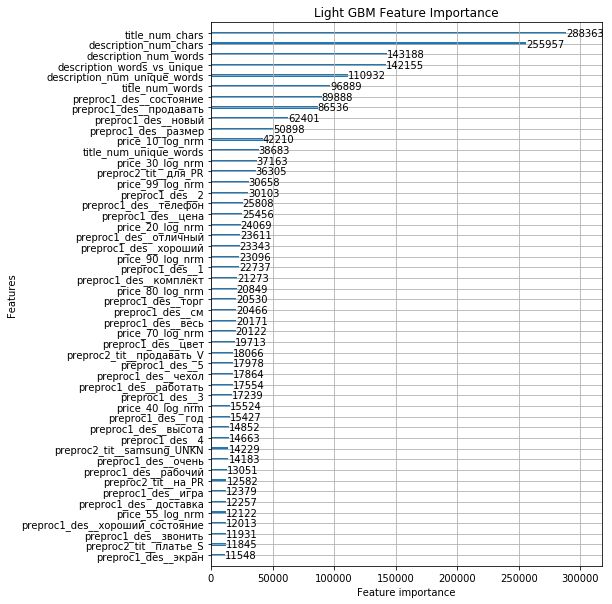

In [206]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')